# <b> *Mercedes Benz Greener Manufacturing* </b>
## <b> <font color = blue> *Part 2: Data Preparation and Modeling*</font> </b>
***

In [129]:
#arrays and dataframes operations 
import os
import math
from pprint import pprint
import statistics
import numpy as np
import pandas as pd
#visualization imports
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style='whitegrid')
%matplotlib inline 
#consistent plot sizes
from pylab import rcParams
rcParams['figure.figsize'] = 12,5
rcParams['axes.labelsize'] = 12
rcParams['xtick.labelsize'] = 12
rcParams['ytick.labelsize'] = 12
#handle unwanted warnings
import warnings
warnings.filterwarnings(action='ignore',category=DeprecationWarning)
warnings.filterwarnings(action='ignore',category=FutureWarning)
#display all the columns
pd.options.display.max_columns = False
#import label encoder
from sklearn.preprocessing import LabelEncoder
#import transformer
from sklearn.preprocessing import PowerTransformer
#import the modeling libraries
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold
#linear models
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.linear_model import ElasticNet
from sklearn.linear_model import Ridge
#ensemble techniqques
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
#xgboost
from xgboost import XGBRegressor
#pipeline
from sklearn.pipeline import Pipeline
#model evaluation
from sklearn.metrics import mean_squared_error
#principal component
from sklearn.decomposition import PCA
####################################################################################################

#set up location & format to save the figures -- > carried from previous file Part 1. 
PROJECT_ROOT_DIR = '.'
IMAGE_PATH = os.path.join(PROJECT_ROOT_DIR,'Images')
os.makedirs(IMAGE_PATH,exist_ok=True)
#function to save the figure - with default values for some arguments
def save_fig(figname,tight_layout=True,fig_extension='png',resolution=300):
    path = os.path.join(IMAGE_PATH,figname+'.'+fig_extension)
    print('Saving your figure ... %s'%(figname))
    if tight_layout:
        plt.tight_layout()
    #save the figure
    plt.savefig(path,format=fig_extension,dpi=resolution)
    print('Your figure is saved !')
####################################################################################################

In [130]:
#load the dataset removed of all the zero variance features .. 
train = pd.read_csv('train_clean.csv',delimiter=',',engine='python')
test = pd.read_csv('test_clean.csv',delimiter=',',engine='python')

In [131]:
test_id = test.copy()

In [132]:
train.head(3)

,ID,y,X0,X1,X2,X3,X4,X5,X6,X8,X10,X12,X13,X14,X15,X16,X17,X18,X19,X20,X21,X22,X23,X24,X26,X27,X28,X29,X30,X31,X32,X33,X34,X35,X36,X37,X38,X39,X40,X41,...,X344,X345,X346,X348,X349,X350,X351,X352,X353,X354,X355,X356,X357,X358,X359,X360,X361,X362,X363,X364,X365,X366,X367,X368,X369,X370,X371,X372,X373,X374,X375,X376,X377,X378,X379,X380,X382,X383,X384,X385
0,0,130.81,k,v,at,a,d,u,j,o,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,1,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0
1,6,88.53,k,t,av,e,d,y,l,o,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,1,0,1,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0
2,7,76.26,az,w,n,c,d,x,j,x,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,1,1,0,1,0,0,0,1,0,1,0,0,0,0,...,0,0,0,1,0,1,0,0,0,1,0,0,0,1,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0


In [133]:
train.drop('ID',axis=1,inplace=True)
test.drop('ID',axis=1,inplace=True)

In [134]:
train.drop('X4',axis=1,inplace=True)
test.drop('X4',axis=1,inplace=True)

In [135]:
#separate out the categorical features from the dataset 
train_cat_features = train.select_dtypes(include='object').columns.tolist()
test_cat_features =  test.select_dtypes(include='object').columns.tolist()

In [136]:
#check if the two list is the same 
train_cat_features == test_cat_features

True

In [137]:
train_num_features = train.select_dtypes(include='int64').columns.tolist()
len(train_num_features)

356

In [138]:
for col in train_num_features:
    train[col] = train[col].astype(str)
    test[col] = test[col].astype(str)

In [139]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4209 entries, 0 to 4208
Columns: 364 entries, y to X385
dtypes: float64(1), object(363)
memory usage: 11.7+ MB


In [140]:
#update the feature types
train_cat_features = train.select_dtypes(include='object').columns.tolist()
test_cat_features =  test.select_dtypes(include='object').columns.tolist()

<font color=blue>_Earlier, the unique values is a few of the categorical features in train and test had different unique values. Hence the label encoder should be fixed based on the complete list of unique values in the train and the test set. Fitting only on the train will result in failure of the label encoder transformation on the test set._</font>

In [141]:
#label encode the categorical features
encoder = LabelEncoder()
for col in train_cat_features:
    encoder.fit(list(train[col].values) + list(test[col].values))
    train[col] = encoder.transform(list(train[col].values))
    test[col] = encoder.transform(list(test[col].values))

In [142]:
train.head()

,y,X0,X1,X2,X3,X5,X6,X8,X10,X12,X13,X14,X15,X16,X17,X18,X19,X20,X21,X22,X23,X24,X26,X27,X28,X29,X30,X31,X32,X33,X34,X35,X36,X37,X38,X39,X40,X41,X42,X43,...,X344,X345,X346,X348,X349,X350,X351,X352,X353,X354,X355,X356,X357,X358,X359,X360,X361,X362,X363,X364,X365,X366,X367,X368,X369,X370,X371,X372,X373,X374,X375,X376,X377,X378,X379,X380,X382,X383,X384,X385
0,130.81,37,23,20,0,27,9,14,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,1,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0
1,88.53,37,21,22,4,31,11,14,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,1,0,1,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0
2,76.26,24,24,38,2,30,9,23,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,1,1,0,1,0,0,0,1,0,1,0,0,0,0,0,1,...,0,0,0,1,0,1,0,0,0,1,0,0,0,1,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
3,80.62,24,21,38,5,30,11,4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,0,1,0,0,0,1,0,1,0,0,0,0,0,1,...,0,0,0,1,0,1,0,0,0,0,0,0,0,1,0,0,1,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0
4,78.02,24,23,38,5,14,3,13,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,0,1,0,0,0,1,0,1,0,0,0,0,0,1,...,0,0,0,1,0,1,0,0,0,0,0,0,0,1,0,0,1,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0


In [143]:
test.head()

,X0,X1,X2,X3,X5,X6,X8,X10,X12,X13,X14,X15,X16,X17,X18,X19,X20,X21,X22,X23,X24,X26,X27,X28,X29,X30,X31,X32,X33,X34,X35,X36,X37,X38,X39,X40,X41,X42,X43,X44,...,X344,X345,X346,X348,X349,X350,X351,X352,X353,X354,X355,X356,X357,X358,X359,X360,X361,X362,X363,X364,X365,X366,X367,X368,X369,X370,X371,X372,X373,X374,X375,X376,X377,X378,X379,X380,X382,X383,X384,X385
0,24,23,38,5,26,0,22,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,0,1,0,0,0,1,0,1,0,0,0,0,0,1,0,...,0,0,0,1,0,1,0,0,0,0,0,0,0,1,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
1,46,3,9,0,9,6,24,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,1,0,0,0,1,0,1,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,1,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0
2,24,23,19,5,0,9,9,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,1,0,0,0,1,0,1,0,0,0,0,0,0,0,...,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
3,24,13,38,5,32,11,13,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,0,1,0,0,0,1,0,1,0,0,0,0,0,1,0,...,0,0,0,1,0,1,0,0,0,0,0,0,0,1,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
4,49,20,19,2,31,8,12,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,1,1,0,0,0,0,0,0,1,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0


### _split the dataset_

In [144]:
X = train.drop('y',axis=1)
y = train['y']
#split into train and validation set -- > the test df is for final prediction and evaluation
X_train, X_test, y_train, y_test = train_test_split(X, y,test_size=0.20,random_state=42)
X_train.shape, X_test.shape

((3367, 363), (842, 363))

### _Baseline Modeling_
<font color = green> _Create a baseline performance using Random Forest Regressor_</font>

In [145]:
#repetitive model
seed = 42

In [146]:
#fit and predict using the defaut 
xg_reg = XGBRegressor(random_state=seed)
xg_reg.fit(X_train,y_train)
xg_reg_predict = xg_reg.predict(X_test)
#model evaluation
mse = mean_squared_error(y_test,xg_reg_predict)
print('Validation MSE:%.2f & Validation RMSE:%.2f'%(mse,np.sqrt(mse)))

Validation MSE:83.50 & Validation RMSE:9.14


Saving your figure ... feature_importance_xgboost
Your figure is saved !


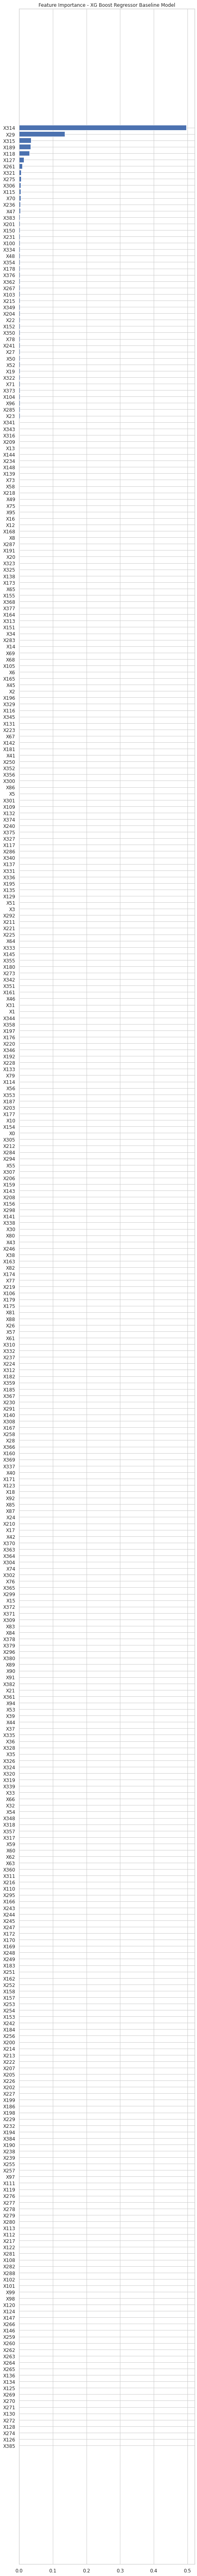

In [147]:
#plot the feature importance of random forest model
sorted_idx = xg_reg.feature_importances_.argsort()
plt.figure(figsize=(7,90))
plt.barh(X.columns[sorted_idx],xg_reg.feature_importances_[sorted_idx])
plt.title('Feature Importance - XG Boost Regressor Baseline Model')
plt.tight_layout()
save_fig('feature_importance_xgboost')
plt.show()

<font color = blue> ***There are only a very few features which are highlighted as top features in the feature importance plot. The modeling execution and performance can be achieved with lesser features. Decomposing the dataset features would be a better option.*** </f>

## _Transform Scale & Dimension Reduction_

In [148]:
warnings.filterwarnings(action='ignore',message='')

#Power Transformation of the inputs
from sklearn.preprocessing import PowerTransformer
pt = PowerTransformer()
X_train = pt.fit_transform(X_train)
X_test = pt.transform(X_test)

#scale the inputs
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [149]:
# Decompose into principal components 
from sklearn.decomposition import PCA
pca = PCA(n_components=0.95)
X_train = pca.fit_transform(X_train)
X_test = pca.transform(X_test)

In [150]:
#check the shape after PCA
X_train.shape

(3367, 145)

In [151]:
#check the shape after PCA
X_test.shape

(842, 145)

In [152]:
pca.explained_variance_ratio_

array([0.07076189, 0.05684704, 0.04498771, 0.03441956, 0.03323585,
       0.0313713 , 0.02867309, 0.02140169, 0.02010208, 0.01772731,
       0.01655513, 0.01586654, 0.0147744 , 0.01464879, 0.01380473,
       0.01330705, 0.01289696, 0.01170286, 0.01127718, 0.01102748,
       0.01003146, 0.00990419, 0.00973732, 0.00960028, 0.00896614,
       0.00872414, 0.00794708, 0.00770103, 0.00728203, 0.00721501,
       0.00702709, 0.00697898, 0.0066694 , 0.0064399 , 0.00626249,
       0.00613646, 0.00593432, 0.00591914, 0.00580787, 0.00572314,
       0.00551178, 0.00546944, 0.00540343, 0.0052619 , 0.00514033,
       0.00509679, 0.00494248, 0.00480009, 0.00461357, 0.00455965,
       0.00443014, 0.00435737, 0.00431061, 0.004229  , 0.00419587,
       0.00412594, 0.00405542, 0.00400457, 0.00389641, 0.00387546,
       0.00380443, 0.00376676, 0.00373287, 0.00367524, 0.00362737,
       0.00359804, 0.00348088, 0.00343383, 0.00341497, 0.00339626,
       0.00336252, 0.00329255, 0.00327652, 0.00323958, 0.00318

In [153]:
#prepare the test data for prediction with the trained model
test_xg = pt.transform(test)
test_xg = scaler.transform(test_xg)
test_xg = pca.transform(test_xg)

## _XGBoost Modeling_

In [154]:
XGBRegressor()

XGBRegressor(base_score=None, booster=None, colsample_bylevel=None,
             colsample_bynode=None, colsample_bytree=None, gamma=None,
             gpu_id=None, importance_type='gain', interaction_constraints=None,
             learning_rate=None, max_delta_step=None, max_depth=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=100, n_jobs=None, num_parallel_tree=None,
             objective='reg:squarederror', random_state=None, reg_alpha=None,
             reg_lambda=None, scale_pos_weight=None, subsample=None,
             tree_method=None, validate_parameters=False, verbosity=None)

In [155]:
# Perform grid search on the XGB Regressor baseline modele with default hyperparameters .. 
xgb_reg = XGBRegressor(random_state=42)

In [156]:
param_grid = [{'n_estimators': [500,700], 'max_depth': [5,8],'eta':[0.1,0.01],
              'booster':['gblinear','gbtree']}]      
  
grid_search = GridSearchCV(estimator=xgb_reg,param_grid=param_grid,n_jobs=-1,cv=3,
                          scoring='r2',return_train_score=True)

In [157]:
#grid_search.fit(X_train,y_train)

In [158]:
#grid_search.best_estimator_

In [159]:
#modeling using XG boost --> added alpha regularizer and sub sample value of 50% 
from xgboost import XGBRegressor
model = XGBRegressor(random_state=42,n_estimators=700,learning_rate=0.01,
                    max_depth=5,subsample=0.5,reg_alpha=0.1,booster='gblinear',
                     feature_selector='shuffle')
 

In [160]:
#fit the model and predict 
model.fit(X_train,y_train)
xg_predict = model.predict(X_test)
xg_train_predict = model.predict(X_train)

In [161]:
#get the r2 score 
from sklearn.metrics import r2_score
r2_train = r2_score(y_train,xg_train_predict)
r2_test = r2_score(y_test,xg_predict)
print('R2 Score XG Boost Regressor on Train Data',r2_train)
print('R2 Score XG Boost Regressor on Test Data',r2_test)

R2 Score XG Boost Regressor on Train Data 0.558803006040021
R2 Score XG Boost Regressor on Test Data 0.5591246040639284


In [162]:
#get the root mean squared error
rmse_train = np.sqrt(mean_squared_error(y_train,xg_train_predict))
rmse_test = np.sqrt(mean_squared_error(y_test,xg_predict))
print('RMSE XG Boost Regressor on Train Data',rmse_train)
print('RMSE XG Boost Regressor on Test Data',rmse_test)

RMSE XG Boost Regressor on Train Data 8.454150913328514
RMSE XG Boost Regressor on Test Data 8.283853497508275


<font color =blue> _The RMSE of the XGB Regressor on the train and the test data is very close. Relatively the model does not overfit or underfit the data_

### _Predict on the test dataset_

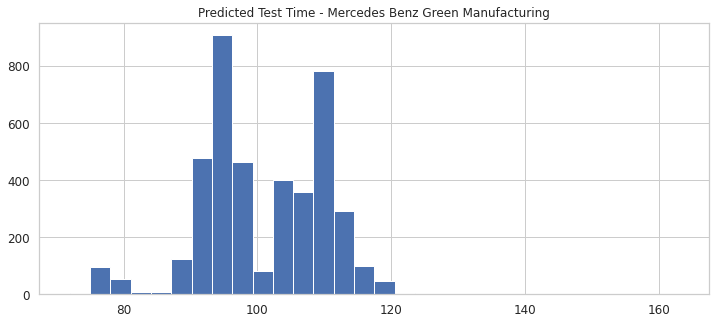

In [163]:
#predict on the test dataset and check distribution of the predicted test bench time 
xg_predictions = model.predict(test_xg)
plt.hist(xg_predictions,bins=30)
plt.title('Predicted Test Time - Mercedes Benz Green Manufacturing')
plt.title
plt.show()

In [164]:
#check the min, mean and the max time it would take to test
xg_predictions.min(), xg_predictions.mean(), xg_predictions.max()

(71.95241, 100.74841, 162.99115)

In [165]:
# this was also a kaggle competition, preparing the submission file. 
test = pd.read_csv('test_clean.csv',delimiter=',',engine='python')

df_test = pd.DataFrame(test['ID'],columns=['ID'])
df_test['y'] = xg_predictions
df_test.head()
df_test.to_csv('mercbenz_xgb.csv',index=False)
